In [1]:
# Import Libraries
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import shapefile as shp
pd.set_option('display.max_columns', None)
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline
import numpy as np
import scipy
import matplotlib

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.utils.data import WeightedRandomSampler

import sklearn
from sklearn.feature_selection import chi2
from sklearn.experimental import enable_halving_search_cv
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import auc
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.multiclass import OneVsRestClassifier
from sklearn.preprocessing import label_binarize
from itertools import cycle

import skorch
from skorch import NeuralNetClassifier
from skorch.callbacks import EpochScoring
from skorch.callbacks import EarlyStopping
from skorch.callbacks import Checkpoint
import time
import pickle
from pprint import pprint

In [2]:
# import data for mlp and svm models
# importing X_train 
X_train_sm_path = "pickle_files/X_train_sm.pickle"
with open(X_train_sm_path, 'rb') as data:
    X_train_sm = pickle.load(data)

In [3]:
# importing y_train 
y_train_sm_path = "pickle_files/y_train_sm.pickle"
with open(y_train_sm_path, 'rb') as data:
    y_train_sm = pickle.load(data)

In [4]:
# importing X_test 
X_test_sm_path = "pickle_files/X_test_sm.pickle"
with open(X_test_sm_path, 'rb') as data:
    X_test_sm = pickle.load(data)

In [5]:
# importing y_test 
y_test_sm_path = "pickle_files/y_test_sm.pickle"
with open(y_test_sm_path, 'rb') as data:
    y_test_sm = pickle.load(data)

In [6]:
# parameters of the network
input_size = 16
hidden = 30  
num_classes = 7                 
dropout = 0.3
activation = F.relu

# hyperparameters of MLP
batch_size = 32
lr = 0.0001
epochs = 300
optimizer = optim.Adam
criterion = nn.CrossEntropyLoss

# base mlp model
class final_mlp(nn.Module):
     def __init__(self, input_size = input_size, 
         hidden = hidden, output_size = num_classes, dropout = dropout,
         activation = activation
     ):
            
        super(final_mlp, self).__init__()
        self.dropout = nn.Dropout(dropout)
        self.activation = activation
        
        self.fc1 = nn.Linear(input_size, hidden)
        self.fc2 = nn.Linear(hidden, hidden)
        self.output = nn.Linear(hidden, num_classes)
 
     def forward(self, x):
        x = self.activation(self.fc1(x))
        x = self.dropout(x)
        x = self.activation(self.fc2(x))
        x = self.dropout(x)
        x = F.softmax(self.output(x), dim=-1)

        return x

In [7]:
# Import the final MLP model train side
final_mlp_train = pickle.load(open('final_models/mlp_final_train.pickle', 'rb'))

In [8]:
# Import the final MLP model test side
final_mlp_test = pickle.load(open('final_models/mlp_final_test.pickle', 'rb'))

In [9]:
# Train accuracy of MLP
pred_mlp_train = final_mlp_train.predict(X_train_sm)
train_accuracy_mlp = accuracy_score(y_train_sm,pred_mlp_train)
print("Train accuracy of MLP: ", train_accuracy_mlp)

Train accuracy of MLP:  0.9311143562112896


In [10]:
# Test accuracy of MLP
pred_mlp_test = final_mlp_test.predict(X_test_sm)
test_accuracy_mlp = accuracy_score(y_test_sm,pred_mlp_test)
print("Test accuracy of MLP: ", test_accuracy_mlp)

Test accuracy of MLP:  0.8869635301229095


In [12]:
# cross validated accuracy of mlp train side
print(cross_val_score(final_mlp_train, X_train_sm, y_train_sm, cv=5));

  epoch    accuracy    train_loss    valid_acc    valid_loss     dur
-------  ----------  ------------  -----------  ------------  ------
      1      0.1429        1.9479       0.1429        1.9465  1.2851
      2      0.1429        1.9457       0.1429        1.9441  0.6552
      3      0.1429        1.9433       0.1429        1.9411  0.6112
      4      0.1819        1.9398       0.1819        1.9364  0.5648
      5      0.3235        1.9341       0.3235        1.9287  0.5922
      6      0.3398        1.9237       0.3398        1.9137  0.6003
      7      0.3342        1.9037       0.3342        1.8837  0.5774
      8      0.3203        1.8729       0.3203        1.8460  0.5903
      9      0.3442        1.8430       0.3442        1.8157  0.5639
     10      0.3962        1.8220       0.3962        1.7935  0.6046
     11      0.4449        1.8032       0.4449        1.7716  0.5984
     12      0.5312        1.7828       0.5312        1.7483  0.5937
     13      0.5620        1.7635 

In [13]:
# cross validated accuracy of mlp test side
print(cross_val_score(final_mlp_test, X_test_sm, y_test_sm, cv=5));

  epoch    accuracy    train_loss    valid_acc    valid_loss     dur
-------  ----------  ------------  -----------  ------------  ------
      1      0.1423        1.9450       0.1423        1.9450  0.1401
      2      0.1423        1.9448       0.1423        1.9446  0.1368
      3      0.1423        1.9444       0.1423        1.9442  0.1279
      4      0.1423        1.9439       0.1423        1.9437  0.1400
      5      0.1423        1.9433       0.1423        1.9432  0.1453
      6      0.1423        1.9435       0.1423        1.9426  0.1487
      7      0.1423        1.9422       0.1423        1.9419  0.1450
      8      0.1423        1.9414       0.1423        1.9410  0.1497
      9      0.1423        1.9408       0.1423        1.9400  0.1499
     10      0.1423        1.9392       0.1423        1.9387  0.1453
     11      0.1423        1.9380       0.1423        1.9371  0.1450
     12      0.1423        1.9366       0.1423        1.9353  0.1432
     13      0.1423        1.9335 

In [14]:
# classification training report of the mlp model
class_report_train_mlp = classification_report(y_train_sm,final_mlp_train.predict(X_train_sm))
print(class_report_train_mlp)

              precision    recall  f1-score   support

           0       0.93      0.91      0.92      2837
           1       1.00      1.00      1.00      2837
           2       0.93      0.92      0.92      2837
           3       0.89      0.92      0.90      2837
           4       0.96      0.96      0.96      2837
           5       0.96      0.96      0.96      2837
           6       0.86      0.85      0.86      2837

    accuracy                           0.93     19859
   macro avg       0.93      0.93      0.93     19859
weighted avg       0.93      0.93      0.93     19859



In [15]:
# classification testing report of the mlp model
class_report_test_mlp = classification_report(y_test_sm,final_mlp_test.predict(X_test_sm))
print(class_report_test_mlp)

              precision    recall  f1-score   support

           0       0.84      0.75      0.79       709
           1       1.00      1.00      1.00       709
           2       0.79      0.83      0.81       709
           3       0.90      0.86      0.88       709
           4       0.97      0.92      0.94       709
           5       0.94      0.94      0.94       709
           6       0.80      0.90      0.85       709

    accuracy                           0.89      4963
   macro avg       0.89      0.89      0.89      4963
weighted avg       0.89      0.89      0.89      4963



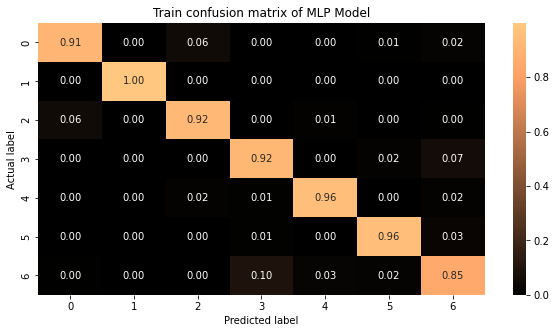

In [16]:
# Train confusion matrix of the mlp model
fig = plt.figure(figsize=(10,5))
con_matrix_train = confusion_matrix(y_train_sm, final_mlp_train.predict(X_train_sm))
# normalizing the data
con_matrix_train = con_matrix_train / np.sum(con_matrix_train, axis=1, keepdims=True)
# creating heatmap for confusion matrix
sns.heatmap(con_matrix_train,annot=True,cmap = 'copper' ,fmt='.2f')
plt.title('Train confusion matrix of MLP Model')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.show()

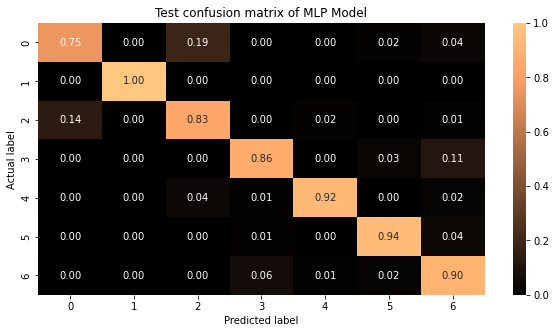

In [17]:
# Test confusion matrix of the mlp model
fig = plt.figure(figsize=(10,5))
con_matrix_test = confusion_matrix(y_test_sm, final_mlp_test.predict(X_test_sm))
# normalizing the data
con_matrix_test = con_matrix_test / np.sum(con_matrix_test, axis=1, keepdims=True)
# creating heatmap for confusion matrix
sns.heatmap(con_matrix_test,annot=True,cmap = 'copper' ,fmt='.2f')
plt.title('Test confusion matrix of MLP Model')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.show()

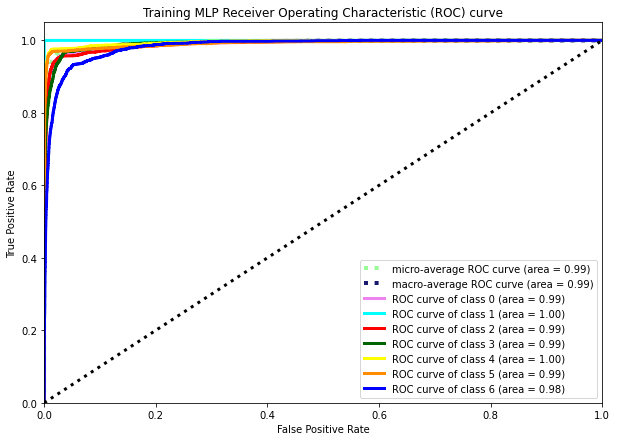

In [19]:
# ROC plot for MLP model train side
# referred from - https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html
def plot_roc_curve(y_train_sm, y_pred_sm, model_sm):
  
  no_of_classes = 7

  # Compute ROC curve and ROC area for each class
  false_pos_r = dict()
  true_pos_r = dict()
  roc_auc = dict()
  for i in range(0,7):
    false_pos_r[i], true_pos_r[i], _ = roc_curve(y_train_sm[:, i], y_pred_sm[:, i])
    roc_auc[i] = auc(false_pos_r[i], true_pos_r[i])
  
  # Compute micro-average ROC curve and ROC area
  false_pos_r["micro_avg"], true_pos_r["micro_avg"], _ = roc_curve(y_train_sm.ravel(), y_pred_sm.ravel())
  roc_auc["micro_avg"] = auc(false_pos_r["micro_avg"], true_pos_r["micro_avg"])

  # First aggregate all false positive rates
  all_false_pos_r = np.unique(np.concatenate([false_pos_r[i] for i in range(0,7)]))

  # Then interpolate all ROC curves at this points
  mean_true_pos_r = np.zeros_like(all_false_pos_r)
  for i in range(0,7):
    mean_true_pos_r += np.interp(all_false_pos_r, false_pos_r[i], true_pos_r[i])

  # Finally average it and compute AUC
  mean_true_pos_r /= no_of_classes

  false_pos_r["macro_avg"] = all_false_pos_r
  true_pos_r["macro_avg"] = mean_true_pos_r
  roc_auc["macro_avg"] = auc(false_pos_r["macro_avg"], true_pos_r["macro_avg"])

  # Plot all ROC curves
  plt.figure(figsize=(10,7))
  colors = matplotlib.cm.get_cmap('tab20')
  colors = colors(np.linspace(0, 3, 7))
  lw = 3
  plt.plot(false_pos_r["micro_avg"], true_pos_r["micro_avg"],
    label="micro-average ROC curve (area = {0:0.2f})".format(roc_auc["micro_avg"]),
    color="palegreen", linestyle=":", linewidth=4)

  plt.plot(false_pos_r["macro_avg"], true_pos_r["macro_avg"],
    label="macro-average ROC curve (area = {0:0.2f})".format(roc_auc["macro_avg"]),
    color="midnightblue", linestyle=":", linewidth=4)

  colors = cycle(["violet","aqua","red","darkgreen", "yellow","darkorange", "blue"])
  for i, color in zip(range(0,7), colors):
    plt.plot(false_pos_r[i], true_pos_r[i], color=color, lw=lw,
        label="ROC curve of class {0} (area = {1:0.2f})".format(i, roc_auc[i]))

  plt.plot([0, 1], [0, 1], "k:", lw=lw)
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel("False Positive Rate")
  plt.ylabel("True Positive Rate")
  plt.title("Training MLP Receiver Operating Characteristic (ROC) curve")
  plt.legend()

mlp_encoding = label_binarize(y_train_sm, classes=[0,1,2,3,4,5,6])
mlp_pre_proba = final_mlp_train.predict_proba(X_train_sm)
plot_roc_curve(mlp_encoding, mlp_pre_proba, 'final_mlp')

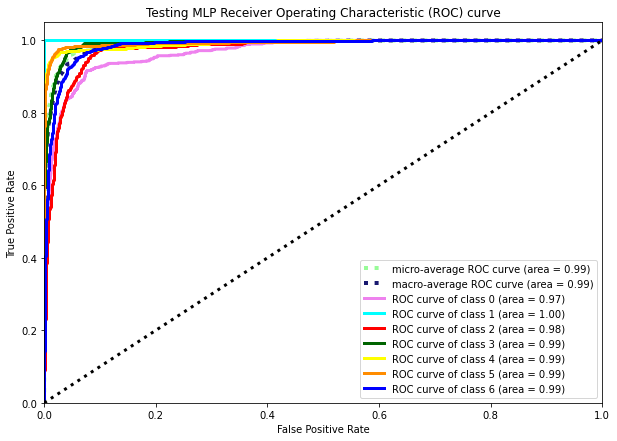

In [20]:
# ROC plot for MLP model test side
# referred from - https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html
def plot_roc_curve(y_test_sm, y_pred_sm, model_sm):
  
  no_of_classes = 7

  # Compute ROC curve and ROC area for each class
  false_pos_r = dict()
  true_pos_r = dict()
  roc_auc = dict()
  for i in range(0,7):
    false_pos_r[i], true_pos_r[i], _ = roc_curve(y_test_sm[:, i], y_pred_sm[:, i])
    roc_auc[i] = auc(false_pos_r[i], true_pos_r[i])
  
  # Compute micro-average ROC curve and ROC area
  false_pos_r["micro_avg"], true_pos_r["micro_avg"], _ = roc_curve(y_test_sm.ravel(), y_pred_sm.ravel())
  roc_auc["micro_avg"] = auc(false_pos_r["micro_avg"], true_pos_r["micro_avg"])

  # First aggregate all false positive rates
  all_false_pos_r = np.unique(np.concatenate([false_pos_r[i] for i in range(0,7)]))

  # Then interpolate all ROC curves at this points
  mean_true_pos_r = np.zeros_like(all_false_pos_r)
  for i in range(0,7):
    mean_true_pos_r += np.interp(all_false_pos_r, false_pos_r[i], true_pos_r[i])

  # Finally average it and compute AUC
  mean_true_pos_r /= no_of_classes

  false_pos_r["macro_avg"] = all_false_pos_r
  true_pos_r["macro_avg"] = mean_true_pos_r
  roc_auc["macro_avg"] = auc(false_pos_r["macro_avg"], true_pos_r["macro_avg"])

  # Plot all ROC curves
  plt.figure(figsize=(10,7))
  colors = matplotlib.cm.get_cmap('tab20')
  colors = colors(np.linspace(0, 3, 7))
  lw = 3
  plt.plot(false_pos_r["micro_avg"], true_pos_r["micro_avg"],
    label="micro-average ROC curve (area = {0:0.2f})".format(roc_auc["micro_avg"]),
    color="palegreen", linestyle=":", linewidth=4)

  plt.plot(false_pos_r["macro_avg"], true_pos_r["macro_avg"],
    label="macro-average ROC curve (area = {0:0.2f})".format(roc_auc["macro_avg"]),
    color="midnightblue", linestyle=":", linewidth=4)

  colors = cycle(["violet","aqua","red","darkgreen", "yellow","darkorange", "blue"])
  for i, color in zip(range(0,7), colors):
    plt.plot(false_pos_r[i], true_pos_r[i], color=color, lw=lw,
        label="ROC curve of class {0} (area = {1:0.2f})".format(i, roc_auc[i]))

  plt.plot([0, 1], [0, 1], "k:", lw=lw)
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel("False Positive Rate")
  plt.ylabel("True Positive Rate")
  plt.title("Testing MLP Receiver Operating Characteristic (ROC) curve")
  plt.legend()

mlp_encoding = label_binarize(y_test_sm, classes=[0,1,2,3,4,5,6])
mlp_pre_proba = final_mlp_test.predict_proba(X_test_sm)
plot_roc_curve(mlp_encoding, mlp_pre_proba, 'final_mlp')

In [22]:
# Import the final SVM model
final_svm = pickle.load(open('final_models/final_svm.pickle', 'rb'))

In [23]:
# print final svm model classification report train side
print(classification_report(y_train_sm,final_svm.predict(X_train_sm)))

              precision    recall  f1-score   support

           0       0.87      0.95      0.91      2837
           1       1.00      1.00      1.00      2837
           2       0.83      0.91      0.87      2837
           3       0.79      0.94      0.86      2837
           4       0.89      0.96      0.92      2837
           5       0.92      0.95      0.93      2837
           6       0.96      0.48      0.64      2837

    accuracy                           0.89     19859
   macro avg       0.89      0.89      0.88     19859
weighted avg       0.89      0.89      0.88     19859



In [24]:
# print final svm model classification report test side
print(classification_report(y_test_sm,final_svm.predict(X_test_sm)))

              precision    recall  f1-score   support

           0       0.88      0.95      0.91       709
           1       1.00      1.00      1.00       709
           2       0.83      0.92      0.87       709
           3       0.76      0.94      0.84       709
           4       0.90      0.94      0.92       709
           5       0.92      0.95      0.93       709
           6       0.97      0.47      0.63       709

    accuracy                           0.88      4963
   macro avg       0.89      0.88      0.87      4963
weighted avg       0.89      0.88      0.87      4963



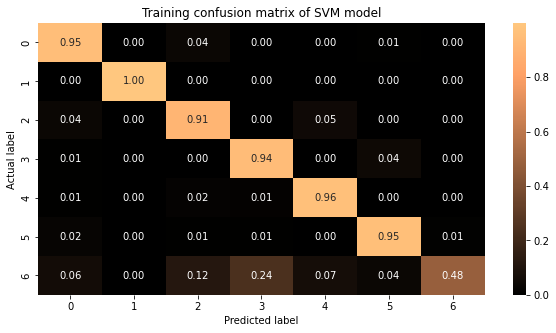

In [25]:
# train confusion matrix of the svm model
fig = plt.figure(figsize=(10,5))
con_matrix_train_svm = confusion_matrix(y_train_sm, final_svm.predict(X_train_sm))
# normalizing the data
con_matrix_train_svm = con_matrix_train_svm / np.sum(con_matrix_train_svm, axis=1, keepdims=True)
# creating heatmap for confusion matrix
sns.heatmap(con_matrix_train_svm,annot=True,cmap = 'copper' ,fmt='.2f')
plt.title('Training confusion matrix of SVM model')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.show()

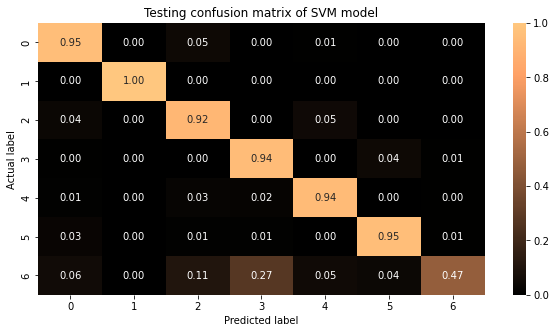

In [26]:
# test confusion matrix of the svm model
fig = plt.figure(figsize=(10,5))
con_matrix_test_svm = confusion_matrix(y_test_sm, final_svm.predict(X_test_sm))
# normalizing the data
con_matrix_test_svm = con_matrix_test_svm / np.sum(con_matrix_test_svm, axis=1, keepdims=True)
# creating heatmap for confusion matrix
sns.heatmap(con_matrix_test_svm,annot=True,cmap = 'copper' ,fmt='.2f')
plt.title('Testing confusion matrix of SVM model')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.show()

In [27]:
# cross validated accuracy of svm train side
print(cross_val_score(final_svm, X_train_sm, y_train_sm, cv=5));

[0.90835851 0.90936556 0.91616314 0.92321249 0.91866029]


In [28]:
# cross validated accuracy of svm test side
print(cross_val_score(final_svm, X_test_sm, y_test_sm, cv=5));

[0.87915408 0.88418933 0.86807654 0.86189516 0.88810484]


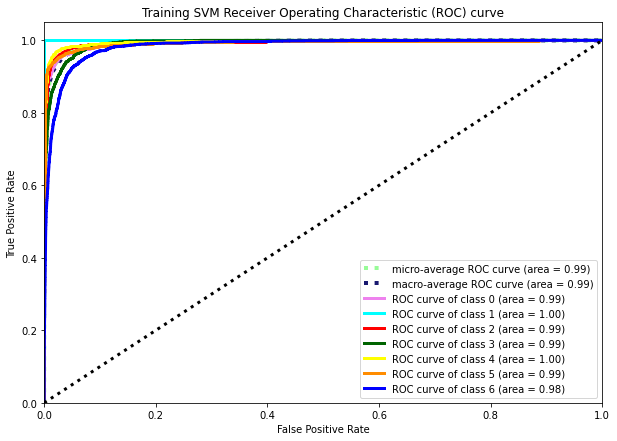

In [29]:
# ROC plot for SVM model train side
# referred from - https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html
def plot_roc_curve(y_train_sm, y_pred_sm, model_sm):
  
  no_of_classes = 7

  # Compute ROC curve and ROC area for each class
  false_pos_r = dict()
  true_pos_r = dict()
  roc_auc = dict()
  for i in range(0,7):
    false_pos_r[i], true_pos_r[i], _ = roc_curve(y_train_sm[:, i], y_pred_sm[:, i])
    roc_auc[i] = auc(false_pos_r[i], true_pos_r[i])
  
  # Compute micro-average ROC curve and ROC area
  false_pos_r["micro_avg"], true_pos_r["micro_avg"], _ = roc_curve(y_train_sm.ravel(), y_pred_sm.ravel())
  roc_auc["micro_avg"] = auc(false_pos_r["micro_avg"], true_pos_r["micro_avg"])

  # First aggregate all false positive rates
  all_false_pos_r = np.unique(np.concatenate([false_pos_r[i] for i in range(0,7)]))

  # Then interpolate all ROC curves at this points
  mean_true_pos_r = np.zeros_like(all_false_pos_r)
  for i in range(0,7):
    mean_true_pos_r += np.interp(all_false_pos_r, false_pos_r[i], true_pos_r[i])

  # Finally average it and compute AUC
  mean_true_pos_r /= no_of_classes

  false_pos_r["macro_avg"] = all_false_pos_r
  true_pos_r["macro_avg"] = mean_true_pos_r
  roc_auc["macro_avg"] = auc(false_pos_r["macro_avg"], true_pos_r["macro_avg"])

  # Plot all ROC curves
  plt.figure(figsize=(10,7))
  colors = matplotlib.cm.get_cmap('tab20')
  colors = colors(np.linspace(0, 3, 7))
  lw = 3
  plt.plot(false_pos_r["micro_avg"], true_pos_r["micro_avg"],
    label="micro-average ROC curve (area = {0:0.2f})".format(roc_auc["micro_avg"]),
    color="palegreen", linestyle=":", linewidth=4)

  plt.plot(false_pos_r["macro_avg"], true_pos_r["macro_avg"],
    label="macro-average ROC curve (area = {0:0.2f})".format(roc_auc["macro_avg"]),
    color="midnightblue", linestyle=":", linewidth=4)

  colors = cycle(["violet","aqua","red","darkgreen", "yellow","darkorange", "blue"])
  for i, color in zip(range(0,7), colors):
    plt.plot(false_pos_r[i], true_pos_r[i], color=color, lw=lw,
        label="ROC curve of class {0} (area = {1:0.2f})".format(i, roc_auc[i]))

  plt.plot([0, 1], [0, 1], "k:", lw=lw)
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel("False Positive Rate")
  plt.ylabel("True Positive Rate")
  plt.title("Training SVM Receiver Operating Characteristic (ROC) curve")
  plt.legend()

svm_encoding = label_binarize(y_train_sm, classes=[0,1,2,3,4,5,6])
svm_pre_proba = final_svm.predict_proba(X_train_sm)
plot_roc_curve(svm_encoding, svm_pre_proba, 'svc_final')

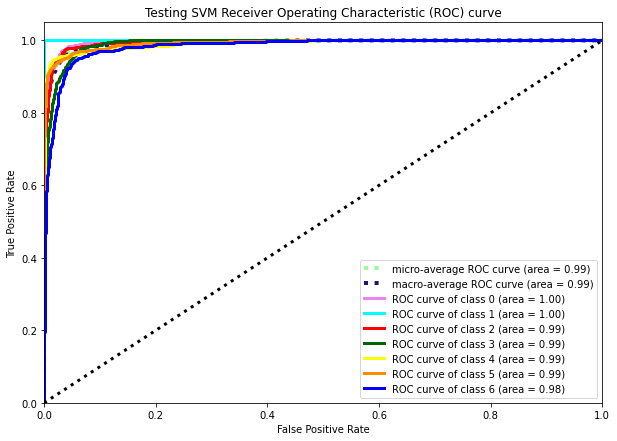

In [30]:
# ROC plot for SVM model train side
# referred from - https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html
def plot_roc_curve(y_train_sm, y_pred_sm, model_sm):
  
  no_of_classes = 7

  # Compute ROC curve and ROC area for each class
  false_pos_r = dict()
  true_pos_r = dict()
  roc_auc = dict()
  for i in range(0,7):
    false_pos_r[i], true_pos_r[i], _ = roc_curve(y_train_sm[:, i], y_pred_sm[:, i])
    roc_auc[i] = auc(false_pos_r[i], true_pos_r[i])
  
  # Compute micro-average ROC curve and ROC area
  false_pos_r["micro_avg"], true_pos_r["micro_avg"], _ = roc_curve(y_train_sm.ravel(), y_pred_sm.ravel())
  roc_auc["micro_avg"] = auc(false_pos_r["micro_avg"], true_pos_r["micro_avg"])

  # First aggregate all false positive rates
  all_false_pos_r = np.unique(np.concatenate([false_pos_r[i] for i in range(0,7)]))

  # Then interpolate all ROC curves at this points
  mean_true_pos_r = np.zeros_like(all_false_pos_r)
  for i in range(0,7):
    mean_true_pos_r += np.interp(all_false_pos_r, false_pos_r[i], true_pos_r[i])

  # Finally average it and compute AUC
  mean_true_pos_r /= no_of_classes

  false_pos_r["macro_avg"] = all_false_pos_r
  true_pos_r["macro_avg"] = mean_true_pos_r
  roc_auc["macro_avg"] = auc(false_pos_r["macro_avg"], true_pos_r["macro_avg"])

  # Plot all ROC curves
  plt.figure(figsize=(10,7))
  colors = matplotlib.cm.get_cmap('tab20')
  colors = colors(np.linspace(0, 3, 7))
  lw = 3
  plt.plot(false_pos_r["micro_avg"], true_pos_r["micro_avg"],
    label="micro-average ROC curve (area = {0:0.2f})".format(roc_auc["micro_avg"]),
    color="palegreen", linestyle=":", linewidth=4)

  plt.plot(false_pos_r["macro_avg"], true_pos_r["macro_avg"],
    label="macro-average ROC curve (area = {0:0.2f})".format(roc_auc["macro_avg"]),
    color="midnightblue", linestyle=":", linewidth=4)

  colors = cycle(["violet","aqua","red","darkgreen", "yellow","darkorange", "blue"])
  for i, color in zip(range(0,7), colors):
    plt.plot(false_pos_r[i], true_pos_r[i], color=color, lw=lw,
        label="ROC curve of class {0} (area = {1:0.2f})".format(i, roc_auc[i]))

  plt.plot([0, 1], [0, 1], "k:", lw=lw)
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel("False Positive Rate")
  plt.ylabel("True Positive Rate")
  plt.title("Testing SVM Receiver Operating Characteristic (ROC) curve")
  plt.legend()

svm_encoding = label_binarize(y_test_sm, classes=[0,1,2,3,4,5,6])
svm_pre_proba = final_svm.predict_proba(X_test_sm)
plot_roc_curve(svm_encoding, svm_pre_proba, 'svc_final')